Importing the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


Modifying RandomMRIDataset() functon for 128x128 slices


In [2]:
class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 128, 128)      # fake MRI slice
        mask = (torch.randn(1, 128, 128) > 0).float()  # fake mask
        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
img.shape, msk.shape

(torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

DataLoader

In [3]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break

torch.Size([8, 1, 128, 128]) torch.Size([8, 1, 128, 128])


Making SimpleCNN more layered

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model = SimpleCNN()
print(model)

# Dummy input of 1 sample, 1 channel, 128x128
dummy_input = torch.randn(1, 1, 128, 128)
output = model(dummy_input)

print(f"Model output shape: {output.shape}") 



SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=1, bias=True)
    (2): Sigmoid()
  )
)
Model output shape: torch.Size([1, 1])


Here, adding a convolution layer, increases model size as new parameters get increased.
Also, we need to alter Linear size to 32 x spatial height x spatial width 

In [6]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))  # dummy target
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000


small encoder-decoder network using mini-U-net

here, we use conv_block

In [7]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape

torch.Size([1, 16, 128, 128])

In [8]:
class MiniUNet(nn.Module):
    """
    A 2-level deep U-Net structure using the defined conv_block.
    """
    def __init__(self, in_channels, out_channels, initial_filters=32):
        super().__init__()
        
        f = initial_filters  # Start channel count (e.g., 32)
        
        # --- 1. Contracting Path (Encoder) ---
        
        # Level 1
        self.encoder1 = conv_block(in_channels, f)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Level 2 (Bottleneck)
        self.encoder2 = conv_block(f, f * 2) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # --- 2. Bottleneck (Bridge) ---
        # Level 3 (Deepest point, downsampled by 4x spatially)
        self.bottleneck = conv_block(f * 2, f * 4) 
        
        # --- 3. Expanding Path (Decoder) ---
        
        # Up-Level 2
        # Use ConvTranspose2d to increase spatial size and reduce channels
        self.upconv2 = nn.ConvTranspose2d(f * 4, f * 2, kernel_size=2, stride=2)
        # Input to decoder conv block is f*2 (from upconv) + f*2 (from skip connection)
        self.decoder2 = conv_block(f * 4, f * 2) 
        
        # Up-Level 1
        self.upconv1 = nn.ConvTranspose2d(f * 2, f, kernel_size=2, stride=2)
        # Input to decoder conv block is f (from upconv) + f (from skip connection)
        self.decoder1 = conv_block(f * 2, f) 
        
        # --- 4. Output Layer ---
        # Final 1x1 convolution to map the final feature maps to the desired output channels/classes
        self.out_layer = nn.Conv2d(f, out_channels, kernel_size=1)
        
    def forward(self, x):
        # 1. ENCODER (Contracting Path)
        e1 = self.encoder1(x)  # H x W x 32 (Saves for skip)
        p1 = self.pool1(e1)    # H/2 x W/2 x 32
        
        e2 = self.encoder2(p1) # H/2 x W/2 x 64 (Saves for skip)
        p2 = self.pool2(e2)    # H/4 x W/4 x 64
        
        # 2. BOTTLENECK
        b = self.bottleneck(p2) # H/4 x W/4 x 128
        
        # 3. DECODER (Expanding Path)
        
        # Up-Level 2
        u2 = self.upconv2(b)    # H/2 x W/2 x 64
        # Skip connection: Concatenate u2 and the saved encoder features (e2)
        u2 = torch.cat([u2, e2], dim=1) 
        d2 = self.decoder2(u2)  # H/2 x W/2 x 64
        
        # Up-Level 1
        u1 = self.upconv1(d2)   # H x W x 32
        # Skip connection: Concatenate u1 and the saved encoder features (e1)
        u1 = torch.cat([u1, e1], dim=1) 
        d1 = self.decoder1(u1)  # H x W x 32
        
        # 4. OUTPUT
        output = self.out_layer(d1)
        
        return output

Verificaion by test inputs

In [9]:
INPUT_CHANNELS = 1 
OUTPUT_CHANNELS = 1 

mini_unet = MiniUNet(in_channels=INPUT_CHANNELS, out_channels=OUTPUT_CHANNELS)

# Dummy input of 1 sample, 1 channel, 128x128 
# Note: For batch size > 1, the shape is [B, C, H, W]
dummy_input = torch.randn(1, 1, 128, 128) 

output = mini_unet(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])


Writing custom Dice Loss function

In [10]:
class DiceLoss(nn.Module):
    
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        # Small constant to prevent division by zero in the denominator
        self.smooth = smooth 

    def forward(self, pred, target):
        # Flatten the tensors for easier element-wise operations and summation.
        # We assume pred and target have the same shape: [B, C, H, W]
        
        # Squeeze the channel dimension if it's 1 (optional, depends on data loader)
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)
        
        # Intersection: element-wise multiplication
        intersection = (pred * target).sum()
        
        # Dice Score calculation
        # The term in the denominator is |A| + |B| (sum of all predicted and ground truth values)
        dice_score = (2. * intersection + self.smooth) / (
            pred.sum() + target.sum() + self.smooth
        )
        
        # Dice Loss is 1 - Dice Score
        dice_loss = 1.0 - dice_score
        
        return dice_loss

now training for random dataset and plotting loss curve

Starting Training (13 batches per epoch)...
Epoch [1/10], Average Loss: 0.432586
Epoch [2/10], Average Loss: 0.333817
Epoch [3/10], Average Loss: 0.332938
Epoch [4/10], Average Loss: 0.333584
Epoch [5/10], Average Loss: 0.333543
Epoch [6/10], Average Loss: 0.333439
Epoch [7/10], Average Loss: 0.333928
Epoch [8/10], Average Loss: 0.333107
Epoch [9/10], Average Loss: 0.333415
Epoch [10/10], Average Loss: 0.333316
Training finished.


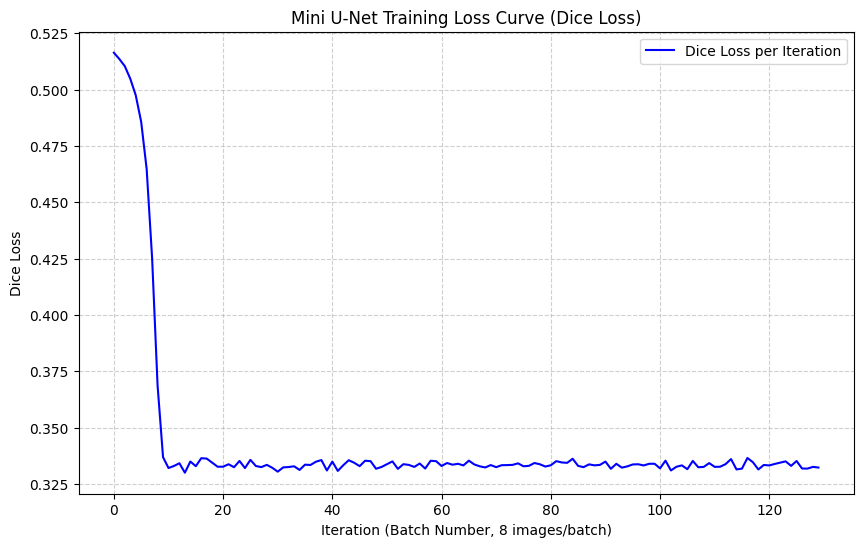

In [12]:
# Configuration
BATCH_SIZE = 8
  # Total data points in the dataset
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
IMG_SIZE = 128
OUTPUT_CHANNELS = 1

# Data Initialization
dataset = RandomMRIDataset()
# DataLoader handles batching and shuffling
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) 

# Model, Loss, and Optimizer
model = MiniUNet(in_channels=1, out_channels=OUTPUT_CHANNELS)
criterion = DiceLoss(smooth=1e-5)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_history = []
step_count = 0

print(f"Starting Training ({len(loader)} batches per epoch)...")

for epoch in range(NUM_EPOCHS):
    model.train() # Set model to training mode
    epoch_loss = 0
    
    for images, masks in loader:
        # --- Training Steps ---
        optimizer.zero_grad()
        
        # Forward pass: model outputs logits
        logits = model(images)
        
        # Apply Sigmoid to logits to get probabilities (for Dice Loss)
        preds = torch.sigmoid(logits)
        
        # Calculate Loss
        loss = criterion(preds, masks)
        
        # Backward pass
        loss.backward()
        
        # Optimization step
        optimizer.step()
        
        # Store loss per batch
        loss_history.append(loss.item())
        epoch_loss += loss.item()
        step_count += 1
    
    avg_epoch_loss = epoch_loss / len(loader)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Average Loss: {avg_epoch_loss:.6f}')

print("Training finished.")

# --- 5. Plotting the Loss Curve ---

plt.figure(figsize=(10, 6))
# Plotting per batch iteration
plt.plot(loss_history, label='Dice Loss per Iteration', color='blue')
plt.title('Mini U-Net Training Loss Curve (Dice Loss)')
plt.xlabel(f'Iteration (Batch Number, {BATCH_SIZE} images/batch)')
plt.ylabel('Dice Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()